# ArClOTs
## Welcome to the Aryl-Chloro/Tosyl (ArClOTs) Selectivity Analysis Project

## Table of Contents
* [Introduction](#Introduction)
  * [Purpose](#Purpose)
  * [Running this Code](#Running-this-Code)
  * [Documentation](#Documentation)
* [Part 1: Evaluate Feasibility of Modeling](#Part-1:-Evaluate-Feasibility-of-Modeling)
  * [Step 1: Loading Libraries](#Step-1:-Loading-Libraries)
  * [Step 2: Getting our Data out of Excel](#Step-2:-Getting-our-Data-out-of-Excel)
  * [Step 3: Change the SMILES Strings into Descriptors](#Step-3:-Change-the-SMILES-Strings-into-Descriptors)
  * [Step 4: Establishing a Baseline](#Step-4:-Establishing-a-Baseline)
  * [Step 5: Training our First Model](#Step-5:-Training-our-First-Model)
  * [Step 6: Summary and Moving Forward](#Step-6:-Summary-and-Moving-Forward)
* [Part 2: Gathering Data with High Throughput Experimentation](#Part-2:-Gathering-Data-with-High-Throughput-Experimentation)
    * [Step 1: Building on the Initial Study](#Step-1:-Building-on-the-Initial-Study)
    * [Step 2: Taking Modeling and Practical Challenges into Account](#Step-2:-Taking-Modeling-and-Practical-Challenges-into-Account)
    * [Step 3: Final Design of the HTE Plate](#Step-3:-Final-Design-of-the-HTE-Plate)
    * [Step 4: Summary and Moving Forward](#Step-4:-Summary-and-Moving-Forward)
* [Part 3: Generating Molecular Descriptors](#Part-3:-Generating-Molecular-Descriptors)
  * [Step 1: Approaching Molecular Descriptors](#Step-1:-Approaching-Molecular-Descriptors)
  * [Step 2: Choosing Molecular Descriptors](#Step-2:-Choosing-Molecular-Descriptors)
  * [Step 3: Generating Electronic Descriptors](#Step-3:-Generating-Electronic-Descriptors)
  * [Step 4: Generating Steric Descriptors](#Step-4:-Generating-Steric-Descriptors)
  * [Step 5: Summary and Moving Forward](#Step-5:-Summary-and-Moving-Forward)
* [Part 4: Modeling with HTE Data](#Part-4:-Modeling-with-HTE-Data)
  * [Step 1: Evaluating New Models](#Step-1:-Evaluating-New-Models)
  * [Step 2: Improving Models](#Step-2:-Improving-Models)
  * [Step 3: Improving our Descriptors](#Step-3:-Improving-our-Descriptors)
  * [Step 4: Summary and Moving Forward](#Step-4:-Summary-and-Moving-Forward)
* [Part 5: Evaluating Model Performance](#Part-5:-Evaluating-Model-Performance)
  * [Step 1: Validate the Trained Model](#Step-1:-Validate-the-Trained-Model)
  * [Step 2: Making Predictions with the Model](#Step-2:-Making-Predictions-with-the-Model)
  * [Step 3: Addition of Existing Phosphines](#Step-3:-Addition-of-Existing-Phosphines)
  * [Step 4: Synthesis of a New Phosphine](#Step-4:-Synthesis-of-a-New-Phosphine)
  * [Step 5: Summary and Moving Forward](#Step-5:-Summary-and-Moving-Forward)
* [Part 6: Conclusions](#Part-6:-Conclusions)

### Introduction
#### Purpose
The intent of this notebook is two-fold:
1. Investigate the reactivity of various phosphine ligands in a selected reaction to determine an ideal candidate for selective reactions.
2. Serve as an example of machine learning in small-molecule organic chemistry.

#### Running this Code
Via _Binder_ you can execute this entire script in your browser with no manual setup required, just some waiting while things are downloaded in the background. After this initial setup, you can scroll through the entire script, see how things work, and play around with different values to see how things change.

#### Documentation
There is a lot of explanation included around all of the code below to help you work through things line for line, with the idea being that you should be left with questions that you can Google and not anything more foundational.

### Part 1: Evaluate Feasibility of Modeling
Before we start running experiments and queuing up expensive simulations, we need to check if the computer can pick up on any of the data we already have. In the original publication, 12 ligands were tested to see if they preferred to insert at the chloro or the tosyl site. We can take the SMILES strings for these ligands along with the selectivity values and try training some models just to see what happens.
If we are able to see even some slight amount of predictivity, it means there is some chance that we can pick up a trend, at which point it will be worth moving forward.

##### Step 1: Loading Libraries
All machine learnings algorithms and chemistry tools that we need have (thankfully) already been written by other people, so all we need to do is install them to our notebook here and them use them freely. Here are some brief explanations of what each of these libraries is for:
 - matplotlib: makes plots
 - pandas: interfacing with excel workbooks
 - numpy: adds more datatypes to python, which need in order to store our data
 - sklearn: has all of the machine learning algorithms
 - rdkit: the infamous cheminformatics software package for loading SMILES strings into various computer-readable formats
 - openpyxl: reading from and writing to excel files
 - ccmblib: handy interface to RDKit to make fingerprint generation easier

In [ ]:
%%capture
# the above line just prevents you from getting hundreds of lines of output from the downloaders
!conda install --yes -c rdkit rdkit
!pip install matplotlib pandas numpy sklearn openpyxl tabulate
!pip install git+https://github.com/vogt-m/ccbmlib
!conda install -y boost-cpp boost py-boost

##### Step 2: Getting our Data out of Excel
Right now, we have an excel sheet with two important columns: SMILES strings for the ligands, and the Cl:OTs selectivity. In order to get this data into Python, we use pandas like this:

In [ ]:
import pandas
data = pandas.read_excel("data/original_paper_data.xlsx", engine='openpyxl')
data

Now let's get the SMILES strings into a list, as well as the selectivity values.

In [ ]:
smiles = data["ligand_smiles"].to_numpy()
smiles

In [ ]:
selectivity = data["ln_selectivity"].to_numpy()
selectivity

Something to note - we are using the natural log of the selectivity value, and not the selectivity value itself. Both are included in the excel workbook, but only so that you can see the relationship between the two. We have to use the natural log of selectivity because selectivity is a ratio. Think about it like this:
 - An unremarkable ligand that did not promote selectivity at all would give a value of 1, which is fine.
 - A fantastic ligand that was highly selective for the Chloro- group would give a value of a 20 or above, which is not in and of itself a problem.
 - A fantastic ligand that was highly selective in _the other direction_ would give a value of 0.05.
 - Now, compare these two fantastic results to the unremarkable result. For the first case, the result is 19 'selectivity units' better. For the fantastic ligand in the other direction though, it is only 0.95 'selectivity units' better.
Selectivity, when presented as a ratio, is _non-linear_. So we take the natural log in order to _linearize_ it and make sure that highly performant ligands stand out in both directions of selectivity.

##### Step 3: Change the SMILES Strings into Descriptors
Your computer needs to have some representation of the molecules in order to draw conclusions about the reactivity; for this, we use RDKit. This package allows us to generate digital representations of the molecules using fingerprints. To do so, we follow this general procedure:
1. import the functions from RDKit that we need to use
2. Make two empty lists to store our molecules and fingerprints.
3. for each of the SMILES strings, generate a molecule
4. for each of the molecules, generate a molecular fingerprint

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np

molecules = []
fingerprints = []

for smile in smiles:
    molecules.append(Chem.MolFromSmiles(smile))

for molecule in molecules:
    # start by generating the fingerprint as a bit vector, which is a list of 1's and 0's
    temp_fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, 2)
    
    # in order to use this later, we need to convert it into an array. to begin, make an empty array
    temp_array = np.array((0,), dtype=np.int8)
    
    # put the fingerprint into the array
    DataStructs.ConvertToNumpyArray(temp_fingerprint, temp_array)
    
    # save this temporary array into the fingerprint array
    fingerprints.append(temp_array)

Take a look at the cell below, which shows what the fingerprints array _actually looks like_. It is a list, and every component of the list is itself a list of 1's and 0's. Each of those sub-lists represents one of the molecules in our dataset, and the computer can interpret the 1's and 0's, as well as their relative placement to one another, as a molecule.

In [ ]:
fingerprints

##### Step 4: Establishing a Baseline
To 'train' our model, we are going to use cross-validation. First, this splits the data into a group of 75% and 25%, lets the model look at the 75% of the data, and then asks it to predict the remaining 25%. Then, it repeats this process but changes around which ligands in the 75% (training data) and which are in the 25% (testing data). This is repeated until all of the samples have been in _both_ the training data and the testing data, which gives us a much better idea of how our model is performing. Graphically, it looks like this:
<div>
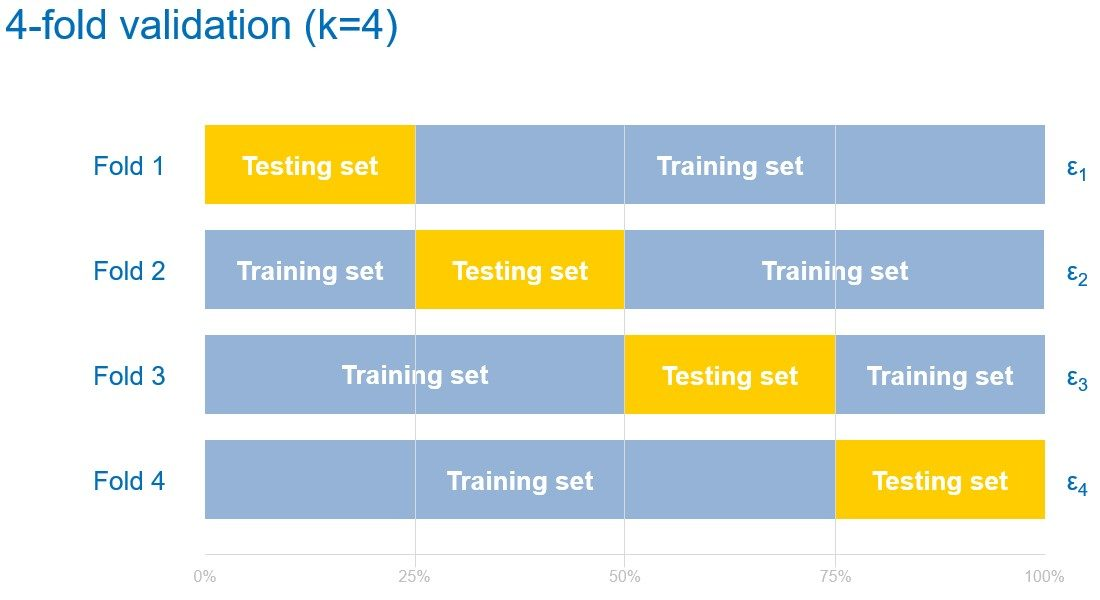
</div>

In [ ]:
from sklearn.model_selection import KFold
# make our groups
groups = KFold(n_splits=6, shuffle=True, random_state=42)

In order to determine if our 'real' models are actually _learning_ anything, we need have a baseline model to which we can make comparisons. There are multiple types of baseline models, and we will explore one here: Guessing the Mean

This approach to determining the selectivity based on the ligand would be to just guess the mean selectivity from the input list every time you are a given a ligand. Sklearn (the library we use to do machine learning in Python) considers this a "dummy" model.

In [ ]:
from sklearn.dummy import DummyRegressor
# setup our mean guessing model
mean_model = DummyRegressor(strategy="mean")

from sklearn.model_selection import cross_val_predict, cross_val_score
mean_score_r2 = cross_val_score(mean_model, fingerprints, selectivity, cv=groups, scoring='r2')
mean_score_MAE = cross_val_score(mean_model, fingerprints, selectivity, cv=groups, scoring='neg_mean_absolute_error')
print(f"Average R2: {mean_score_r2.mean():.2f} +/- {mean_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*mean_score_MAE.mean():.2f} +/- {mean_score_MAE.std():.2f}")

This is totally _dismal_ performance. The R^2 values are terrible to the point of being meaningless. The mean absolute error is actually telling us something. MAE is essentially saying "on average, how far off was each prediction?" For us, guessing the mean every time usually gave us an error of about 2.18 'ln(selectivity)'. Our dataset only included examples from -1.8 to 4.6, so this really is quite bad.

Let's plot the results and figure out why it did so poorly. The plot we are making in the code below is called a 'Prediction Error Plot'.

In [ ]:
mean_predictions = cross_val_predict(mean_model, fingerprints, selectivity, cv=groups)
mean_predictions

In [ ]:
from helper_functions import prediction_error_plot

prediction_error_plot(selectivity, mean_predictions, title='Mean-Guessing Prediction Error')

This is clearly not learning at all, as the predictions go straight across the plot parallel to the x axis. This is the 'model' to beat.

##### Step 5: Training our First Model
Now that we have an idea of the worst case performance, let's start training some actual models to see if they can learn anything. The first one we will try will use the molecular fingerprints which we generated earlier as the input, and the type of model we train is called a Random Forest Regressor. Read about this more on [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).
This code is copy-pasted from above, with just some minor changes to which model it uses. If we wanted to, we could put all of this into it's own separate function, but that would get really confusing really fast, so we will stick with this.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(criterion="mae")

random_forest_score_r2 = cross_val_score(
    random_forest_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='r2',
)
random_forest_score_MAE = cross_val_score(
    random_forest_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)
print(f"Average R2: {random_forest_score_r2.mean():.2f} +/- {random_forest_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*random_forest_score_MAE.mean():.2f} +/- {random_forest_score_MAE.std():.2f}")

An improvement but still not great. Let's look at the plot.

In [ ]:
random_forest_predictions = cross_val_predict(random_forest_model, fingerprints, selectivity, cv=groups)
prediction_error_plot(selectivity, random_forest_predictions, title='Random Forest Prediction Error')

While the error metrics don't look great on this model, the plot tells a slightly different story. The random forest model is learning _something_ because there is some slight curvature to the plot, in addition to the increased accuracy. Let's try another model, this time the Nearest-Neighbors ([Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)), to see if it makes a difference.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neighbors_model = KNeighborsRegressor()

neighbors_score_r2 = cross_val_score(
    neighbors_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='r2',
)
neighbors_score_MAE = cross_val_score(
    neighbors_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)
print(f"Average R2: {neighbors_score_r2.mean():.2f} +/- {neighbors_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*neighbors_score_MAE.mean():.2f} +/- {neighbors_score_MAE.std():.2f}")

random_forest_predictions = cross_val_predict(neighbors_model, fingerprints, selectivity, cv=groups)
prediction_error_plot(selectivity, random_forest_predictions, title='K-Nearest Neighbors Prediction Error')

K-Nearest Neighbors is not particularly outstanding here. The R^2 value is a bit better than the baseline model, but not as good as the random forest, and the error is pretty much equal to the baseline.

Just for completeness sake, let's train a Linear Regression and see how it does.

In [ ]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

linear_score_r2 = cross_val_score(
    linear_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='r2',
)
linear_score_MAE = cross_val_score(
    linear_model,
    fingerprints,
    selectivity,
    cv=groups,
    scoring='neg_mean_absolute_error',
)
print(f"Average R2: {linear_score_r2.mean():.2f} +/- {linear_score_r2.std():.2f}")
print(f"Average Mean Absolute Error: {-1*linear_score_MAE.mean():.2f} +/- {linear_score_MAE.std():.2f}")

linear_predictions = cross_val_predict(linear_model, fingerprints, selectivity, cv=groups)
prediction_error_plot(selectivity, linear_predictions, title='Linear Regression Prediction Error')

Surprise, surprise! Simple linear regression is actually able to decrease the overall error, increase the R^2, _and_ get some of the ligands correct. Linear regression is actually a reasonable approach to take here, given how few data points we have. 

##### Step 6: Summary and Moving Forward
Now that we have some models and results in hand, let's throw them into a nice table and see how we are doing.

In [ ]:
from tabulate import tabulate
print(tabulate(
    [["Mean Baseline",mean_score_r2.mean(),-1*mean_score_MAE.mean()],
     ["Random Forest",random_forest_score_r2.mean(),-1*random_forest_score_MAE.mean()],
     ["K-Nearest",neighbors_score_r2.mean(),-1*neighbors_score_MAE.mean()],
     ["Linear",linear_score_r2.mean(),-1*linear_score_MAE.mean()]],
    headers=["Model","R2","MAE"],
    floatfmt=".2f",
    tablefmt='grid',
))

Using an online comparison of means calculator (you could do this in Python, but... why?) we can determine that the Linear Regression model is statistically different from the Baseline based on the MAE, which is a good sign. Without the incorporation of any specific descriptors or any tuning of the models, we have been able to beat the baseline.

Armed with this, we can move forward to the next step of the investigation.

### Part 2: Gathering Data with High Throughput Experimentation
Now that we know a model could _theoretically_ learn and predict from data about this problem, we need to generate some additional data. Any model that we train is going to need to have enough results to look at and draw conclusions -- by increasing the amount of data, we can drown out experimental and random error, increase the total range of selectivity represented in the data, and give the model enough evidence from which to draw conclusions. 

We are going to do this by High Throughput Experimentation, screening a set of phosphine ligands. Our choice of ligands is going to be guided by the idea of exploring more "chemical space". This means we want to add some phosphines that the data does not include right now, but also try phosphines which are combinations of existing ligands already in the data (and would therefore 'fill in the gap' between existing data points.

##### Step 1: Building on the Initial Study
The initial study included the 12 phoshpine ligands listed below:

|Number|Ligand|
|---|---|
|1| triphenylphosphine|
|2| tri(4-methoxyphenyl)phosphine|
|3| tri(4-fluorophenyl)phosphine|
|4|dimethylphenylphosphine|
|5|diethylphenylphosphine|
|6|diphenylmethylphosphine|
|7|tricyclohexylphosphine|
|8|tributylphosphine|
|9|tri(iso-butyl)phosphine|
|10|bis(diclyclohexylphosphino)ferrocene|
|11|triethylphosphine|
|12|trimethylphosphine|

First, let's think about things we need to add. Experience tells us that this table is missing a few notable functional groups, substitution patterns, and ligand archetypes. In our HTE experiment, we need to add the tert-butyl, adamantyl, amine, and benzyl groups. We will also add some alkyl-substituted aryl groups. Finally, we will add a ligand from the Buchwald class, conspicuously absent from this initial study.

Second, let's think about what combinations of existing pieces we want to explore. Thankfully, phosphine chemistry is pretty well established and we can more or less mix-and-match alkyl and aryl groups to our heart's desire. We will try ethyldiphenylphosphine, which is a combination of methyldiphenylphosphine and diethylphenylphosphine, in order to explore the chemical space between our existing examples.

##### Step 2: Taking Modeling and Practical Challenges into Account
As part of our HTE screen, we definitely want to include the ligands from the original study in order to ensure reproducibility. However, there are some out of this set of 12 which we cannot readily include.

First, the trimethylphosphine would be quite difficult to run in our HTE format. Because the boiling point is around 36 degrees Celsius, we cannot readily 'plate' the ligand (deposit the solid in an HTE vial). While we _could_ run a separate reaction on the bench using trimethylphosphine, this would introduce new question of systematic error which we could not address. For this reason, we will leave trimethylphosphine out.

Second is the bidentate ferrocene ligand. There are two challenges with this species which we are not yet equipped to deal with, and they both occur on the modeling side:
 1. Our simulations used for calculating descriptors do not take into account the number of ligands coordinated to the transition metal center.

This an issue because of systematic error. In our treatment of the system, we ignore the ligation state of the nickel and generate our molecular descriptors based on _only_ a single phosphine. This is 'wrong' (since the complex likely has at least 2 ligands) but because we treat every ligand the same way, our results will not be affected. In the case of bidentate ligands, we cannot make this same underlying assumption, as the bidentate may be the only ligand in the complex and therefore any descriptors generated would actually be giving a complete picture.
Think of it this way: we have a balance which we _know_ is consistently off by a given amount. If we measure all of our chemicals without calibrating it, the values might not be representative of the _actual_ value, but they will all be wrong by the _same amount_. If we were to calculate molecular descriptors for the bidentate phosphine, this would be like calibrating the balance correctly for only _one_ of the compounds we measure.

 2. Ferrocene does not readily converge in computational chemistry simulations when simulated on its own.

As we will discuss in greater detail below, we are going to calculate molecular descriptors for these phosphines by treating them as three separate fragments -- each of the three substituents on the central phosphorus is one fragment. The challenge with this approach is that ferrocene will often not work in simulations unless it is part of the entire molecule. For this reason, we will leave it out of the dataset.

##### Step 3: Final Design of the HTE Plate
With all of the above considerations in mind, here is the layout of the final 96-well HTE plate proposed for initial investigation:

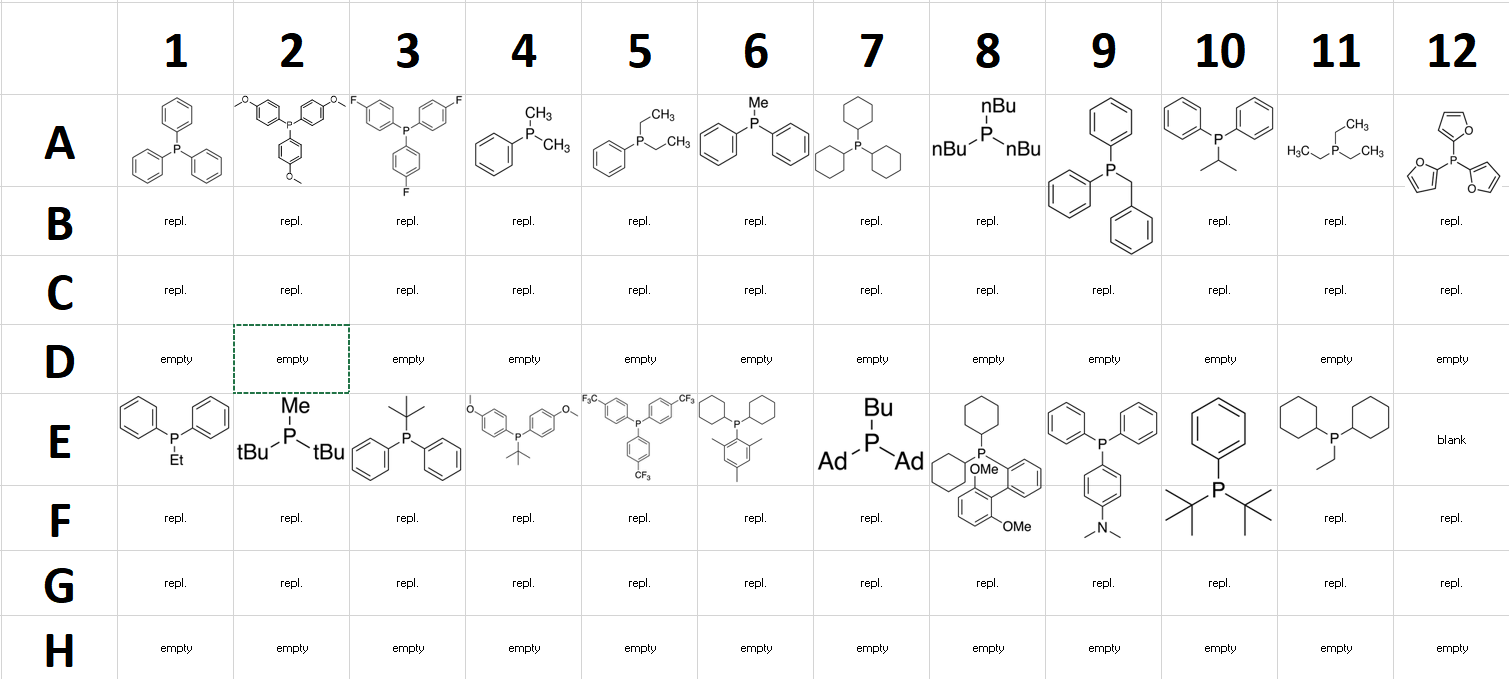

First and foremost -- for each of the ligands on the plate, we will run 4 replicates. This gives us enough data to throw out failed reactions (from bad plating, solvent evaporation, failed injections, etc.) and to do some error analysis, if required.
Now, let's look at the ligands themselves. The top row of 12 is the same as the original study, except those few from the original dataset which we mentioned would be impractical to implement have been replaced by other phosphines. In the second row we have entirely new phosphines selected from our ligand library. Among all of the new phosphines, we have added Buchwald-types ligands, heterocycles, and a number of functional groups which were not present before. Many of the new additions are also combinations of ligands which were already present, such as the aforementioned ethyldiphenylphosphine. We only have 24 ligands total, but we are going to be able to run this all at once and analyze it automatically overnight -- the _rate_ at which we are generating data is enormous.

##### Step 4: Summary and Moving Forward
With this plate design in hand, we need to actually do some legwork and generate the data. This involves designing the experiment to involve as few additions as possible, picking out vials of ligand to put into the plate, spinning it under vacuum, letting the LC/MS sample each well, and retrieving the data off the computer. We also need a calibration curve to correlate this back into yields afterward, from which we can calculate selectivity values like we have above.

These steps will not be covered in the tutorial, so moving forward we are going to assume you have done all the analysis and now have access to a table of data that looks something like this:

|Ligand|ln(Selectivity)|
|---|---|
|triethylphoshine|1.2|
|diphenylbenzylphosphine|0.5|

...and so on.

### Part 3: Generating Molecular Descriptors

##### Step 1: Approaching Molecular Descriptors
Typical literature approach
Our unique approach
combinatorics

##### Step 2: Choosing Molecular Descriptors
- add section for fingerprinting with ccbmlib, which does not guarantee uniform-length outputs and will therefore necessitate zero padding. 
 - switch descriptor calculation to PADEL-Py.
 
##### Step 3: Generating Electronic Descriptors


##### Step 4: Generating Steric Descriptors

##### Step 5: Summary and Moving Forward


### Part 4: Modeling with HTE Data
 - For model tuning, do auto-tuning via hyperparmeter searching sklearn or maybe an evolutionary algorithm.
 - When improving descriptors, increase fingerprint length to 4096 bits

##### Step 1: Evaluating New Models
LASSO, Ridge

##### Step 2: Improving Models

##### Step 3: Improving our Descriptors
Make fingerprints longer, combining descriptors, feature selection (descriptor ablation).

##### Step 4: Summary and Moving Forward

### Part 5: Evaluating Model Performance

##### Step 1: Validate the Trained Model
Holdout sets, straw models with random descriptors.

##### Step 2: Making Predictions with the Model

##### Step 3: Addition of Existing Phosphines
Experimental evaluation is absolutely key to verifying model performance.

##### Step 4: Synthesis of a New Phosphine

##### Step 5: Summary and Moving Forward


### Part 6: Conclusions